# Cost functions

In [ ]:
def hour_cost(q,gxp,d,Xb,Ce,Cv):
  if gxp > d: # is the generation higher than the demand?
    s = gxp - d 
    if s > Xb-q: # is the overgeneration capable of filling the batteries
      qn = Xb
      dc = -Cv*(s-(Xb-q))
      case = 1
      e_r = -(s-(Xb-q)) # electricity from the network
      e_s = d           # electricity from the solar panels
      e_b = Xb-q        # electricity to the battery
    else:
      qn = q + s # load the batteries
      dc = 0
      case = 2
      e_r = 0
      e_s = d
      e_b = s
  else:
    if d - gxp > q: # is the leftover demand higher than the load in the batteries?
      qn = 0
      dc = Ce*(d-gxp-q)
      case = 3
      e_r = d-gxp-q
      e_s = gxp
      e_b = -q
    else:
      qn = q - (d-gxp)
      dc = 0
      case = 4
      e_r = 0
      e_s = gxp
      e_b = -(d-gxp)
  #print(f"demmand {d}, power {gxp}, batttery {q}, {qn}, case {case}")
  return dc, qn, case, e_r, e_s, e_b

def electricity_cost(Xp,Xb,gv, dv, N, Ce, Cv, qinit):
  c = 0
  q = qinit
  if q>Xb:
    q = Xb
  qv = []
  casev = []
  e_rv, e_sv, e_bv = [],[],[]
  for i in range(N):
    [dc, q, case, e_r, e_s, e_b] = hour_cost(q, Xp*gv[i], dv[i], Xb, Ce, Cv)
    c += dc
    qv.append(q)
    casev.append(case)
    e_sv.append(e_s)
    e_bv.append(e_b)
    e_rv.append(e_r)
  return c, qv, casev, e_rv, e_sv, e_bv

def total_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp, Ninit = 2):
  ecost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit)
  for i in range(Ninit):
    ecost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, battery_charge[-1]) # call it twice to use a better init battery charge

  fixcost = Xb*Cb/Vb + Xp*Cp/Vp
  npe_rv = np.asarray(e_rv) 
  rcost = npe_rv[npe_rv> 0].sum() # electricity from the network
  total_cost = ecost + fixcost
  return total_cost, rcost

def multi_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp, Ninit = 2):
  total_cost_d, rcost = total_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
  Ci = Xb*Cb + Xp*Cp
  T = Ci/total_cost_d
  return [total_cost_d, rcost, Ci, T]

def plot_fig(t,demand,irradiance,Xp,Xb,battery_charge,e_rv,name,title=''):
  tnp =np.asarray([*t])
  width= 0.25
  plt.figure()#figsize=(15,8))
  #plt.rcParams.update({'font.size': 20})
  plt.bar(tnp,demand, width,label='Electricity Demand')
  plt.bar(tnp+1*width,np.array(irradiance)*Xp, width, label='Solar Generation')
  plt.bar(tnp+2*width,battery_charge, width, label='Battery Charge')
  #plt.scatter(t,[casei*60/4 for casei in casev],label='Case')
  plt.bar(tnp+3*width,e_rv, width,label='Electricity from(>0) and to(<0) the grid')
  plt.xlabel('Time (h)')
  plt.title(title)
  plt.ylabel('Electricity (kWh)')
  #plt.legend(prop={'size': 12}) 
  #plt.grid()
  plt.savefig(name, bbox_inches='tight')

# Example Data

## Import Data

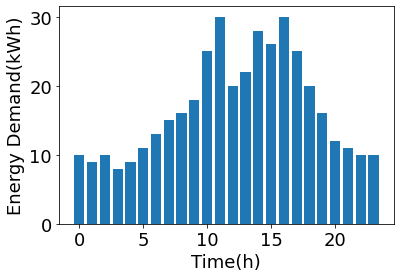

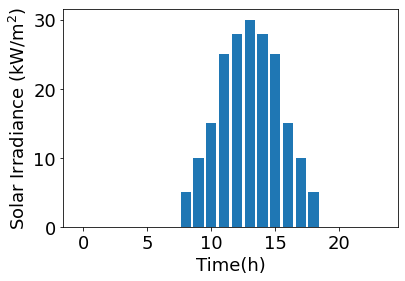

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data
t = range(24)
demand = [10,9,10,8,9,11,13,15,16,18,25,30,20,22,28,26,30,25,20,16,12,11,10,10]
irradiance = [ 0,0,0,0,0,0,0,0,5,10,15,25,28,30,28,25,15,10,5,0,0,0,0,0]

# Plot Sample Data
plt.rcParams.update({'font.size': 18})
plt.bar(t,demand)
plt.xlabel('Time(h)')
plt.ylabel('Energy Demand(kWh)')
plt.savefig('energy_dummy.pdf', bbox_inches='tight')

plt.figure()
plt.bar(t,irradiance)
plt.xlabel('Time(h)')
plt.ylabel('Solar Irradiance (kW/m$^2$)')
plt.savefig('irradiance_dummy.pdf', bbox_inches='tight')
plt.show()

## Test Costs

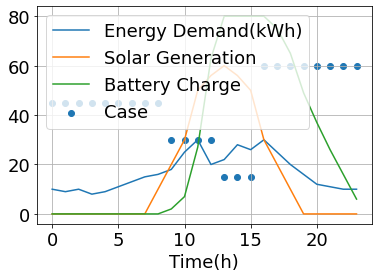

In [ ]:
# Use example parameters
Ce = 1
Cv = 0.5
N = 24
Xb = 80
Xp = 2
qinit = 0

cost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit)

# Plot Sample Data
plt.plot(t,demand)
plt.plot(t,np.array(irradiance)*Xp)
plt.plot(t,battery_charge)
plt.scatter(t,[casei*60/4 for casei in casev])
plt.xlabel('Time(h)')
plt.legend(['Energy Demand(kWh)','Solar Generation','Battery Charge','Case'])
plt.grid()
plt.show()

## Test using isolated solution

In [ ]:
Cb, Vb, Cp, Vp = 0.25,1,170,1 # the good numbers, do not touch

dt = sum(demand)
gt = sum(irradiance)
print(f'd_T is {dt}, g_t is {gt}')
Xp_iso = dt/gt
N = 24
q = []
qn = 0
for i in range(N):
  qn = qn + Xp_iso*irradiance[i] - demand[i]
  q.append(qn)

Xb_iso = max(q)-min(q)
qinit_iso = -min(q)
qinit = qinit_iso
print(f'Isolated solution: Xp {Xp_iso}, Xb {Xb_iso}')
cost_elec_iso, battery_charge_elec_iso, casev_elec_iso, e_rv_elec_iso, e_sv_elec_iso, e_bv_elec_iso = electricity_cost(Xp_iso,Xb_iso,irradiance, demand, N, Ce, Cv, qinit)
print(f'Variable Electricity cost is {cost_elec_iso}')
cost_iso, rcost_panels_elec_iso = total_cost(Xp_iso,Xb_iso,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
print(f'Total Electricity cost is {cost_iso}')

d_T is 404, g_t is 196
Isolated solution: Xp 2.061224489795918, Xb 163.77551020408163
Variable Electricity cost is 1.7763568394002505e-15
Total Electricity cost is 391.35204081632656


## Grid Test

eta 0.5
Cp/Vp/g_T 0.8673469387755102, Ce 1 Cv 0.5
CB/VB/Ce/(1-eta) 0.5


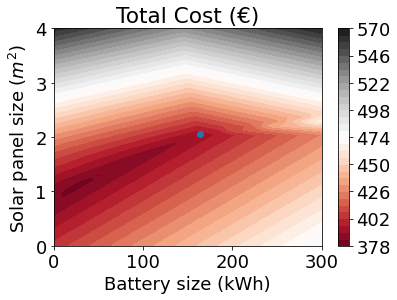

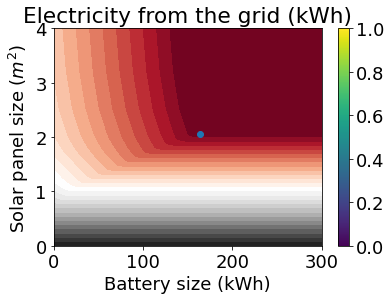

In [ ]:
Xbv = np.linspace(0,300,50).tolist()
Xpv = np.linspace(0,4,50).tolist()
Cb, Vb, Cp, Vp = 0.25,1,170,1 # the good numbers, do not touch
#Cb, Vb, Cp, Vp = 0.45,1,130,1 # the good numbers, do not touch

#Cb, Vb, Cp, Vp = 0.01,1,100,1

xi_P = Cp/Vp/gt
eta = Cv/Ce
print(f'eta {eta}')

print(f'Cp/Vp/g_T {xi_P}, Ce {Ce} Cv {Cv}')
print(f'CB/VB/Ce/(1-eta) {Cb/Vb/Ce/(1-eta)}')

cost_grid = np.zeros([len(Xbv),len(Xpv)])
rcost_grid = np.zeros([len(Xbv),len(Xpv)])
for i,Xb in enumerate(Xbv):
  for j,Xp in enumerate(Xpv):
    qinit = qinit_iso # Xb/2
    cost_grid[j,i],rcost_grid[j,i] = total_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)

plt.figure()
plt.contourf(Xbv, Xpv, cost_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Total Cost (€)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.savefig('xbxp_contour.pdf', bbox_inches='tight')

plt.figure()
plt.contourf(Xbv, Xpv, rcost_grid, 30, cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Electricity from the grid (kWh)')
plt.colorbar(cmap='RdGy')
plt.savefig('xbxp_rcontour.pdf', bbox_inches='tight')

## Plot the Initial Cost and Time to break even 

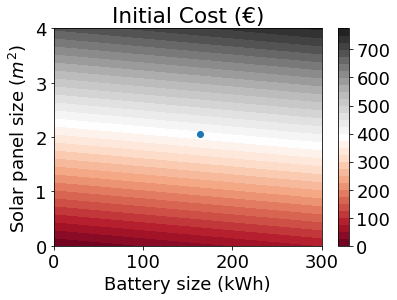

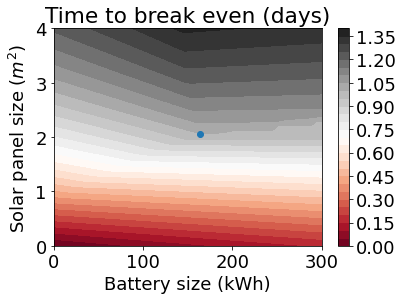

In [ ]:
ci_grid = np.zeros([len(Xbv),len(Xpv)])
T_grid = np.zeros([len(Xbv),len(Xpv)])
for i,Xb in enumerate(Xbv):
  for j,Xp in enumerate(Xpv):
    qinit = qinit_iso # Xb/2
    f = multi_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
    ci_grid[j,i],T_grid[j,i] = f[2],f[3]
    
plt.figure()
plt.contourf(Xbv, Xpv, ci_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Initial Cost (€)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.savefig('xbxp_contour.pdf', bbox_inches='tight')

plt.figure()
plt.contourf(Xbv, Xpv, T_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Time to break even (days)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.savefig('xbxp_rcontour.pdf', bbox_inches='tight')

## Check the solution without batteries

eta 0.5
Cp/Vp/g_T 0.8673469387755102, Ce 1 Cv 0.5
CB/VB/Ce/(1-eta) 0.5


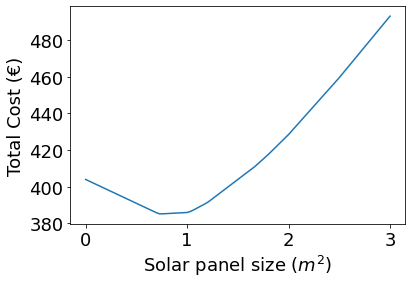

In [ ]:
# line test
Xpv_pcost = np.linspace(0,3,100).tolist()
#Cb, Vb, Cp, Vp = 0.25,1,170,1 # the good numbers, do not touch
#Cb, Vb, Cp, Vp = 0.01,1,100,1

xi_P = Cp/Vp/gt/Ce

eta = Cv/Ce
print(f'eta {eta}')
print(f'Cp/Vp/g_T {xi_P}, Ce {Ce} Cv {Cv}')
print(f'CB/VB/Ce/(1-eta) {Cb/Vb/Ce/(1-eta)}')

cost_panels = np.zeros([len(Xpv_pcost),])
for j,Xp in enumerate(Xpv_pcost):
  qinit = qinit_iso # Xb/2
  Xb = 0
  cost_panels[j],rcost_panels = total_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)

plt.figure()
plt.plot(Xpv_pcost,cost_panels)
plt.xlabel('Solar panel size ($m^2$)')
plt.ylabel('Total Cost (€)')
plt.savefig('cost_only_panels.pdf', bbox_inches='tight')


test using no batteries solution

# Optimize problem

## Use jmetalpy example

In [ ]:
## Use jmetalpy example
!pip install jmetalpy 

from jmetal.algorithm.multiobjective import NSGAII
from jmetal.operator import SBXCrossover, PolynomialMutation
from jmetal.problem import ZDT1
from jmetal.util.termination_criterion import StoppingByEvaluations

problem = ZDT1()

algorithm = NSGAII(
    problem=problem,
    population_size=100,
    offspring_population_size=100,
    mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
    crossover=SBXCrossover(probability=1.0, distribution_index=20),
    termination_criterion=StoppingByEvaluations(max_evaluations=25000)
)

algorithm.run()
from jmetal.util.solution import get_non_dominated_solutions, print_function_values_to_file, print_variables_to_file

front = get_non_dominated_solutions(algorithm.get_result())

# save to files
print_function_values_to_file(front, 'FUN.NSGAII.ZDT1')
print_variables_to_file(front, 'VAR.NSGAII.ZDT1')
from jmetal.lab.visualization import Plot

plot_front = Plot(title='Pareto front approximation', axis_labels=['x', 'y'])
plot_front.plot(front, label='NSGAII-ZDT1', filename='NSGAII-ZDT1', format='png')

     |████████████████████████████████| 112kB 2.9MB/s 
  Created wheel for jmetalpy: filename=jmetalpy-1.5.5-cp36-none-any.whl size=196214 sha256=7a2a01db537f76cbe1b74582873d422e4774fc57ac2540f99b82baf12e33cd4f
  Stored in directory: /root/.cache/pip/wheels/d0/ae/f5/6493b2f72d1311cf8f97e283039fb225f4743879bd04345a9e
Successfully built jmetalpy


2020-09-19 07:20:37,210 [MainThread  ] [INFO ]  Output file (function values): FUN.NSGAII.ZDT1
2020-09-19 07:20:37,213 [MainThread  ] [INFO ]  Output file (variables): VAR.NSGAII.ZDT1
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Create optimization problem
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.algorithm.singleobjective import LocalSearch, SimulatedAnnealing
import numpy as np

class EnergyBuilding(FloatProblem):
    
    def __init__(self, irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp, xp_min):
        super().__init__()

        self.irradiance =irradiance
        self.demand = demand
        self.N = N
        self.Ce= Ce
        self.Cv= Cv
        self.qinit = qinit
        self.Cb= Cb
        self.Vb= Vb
        self.Cp= Cp
        self.Vp= Vp
        
        # initial parameters
        self.number_of_variables = 2 # decision variables
        self.number_of_objectives = 1 
        self.number_of_constraints = 2
        self.lower_bound = [0,0]#[0.0 for _ in range(number_of_variables)]
        self.upper_bound = [xp_min,300] #[1.0 for _ in range(number_of_variables)]
        
        self.obj_directions = [self.MINIMIZE] # both objectives should be minimized
        self.obj_labels = ['cost'] # objectives' name
              
    def evaluate(self, solution) -> FloatSolution:
        '''
        define the way to evaluate one solution, i.e., calculate the objectives of each solution
        '''
        Xp = solution.variables[0]
        Xb = solution.variables[1]
        f1,f2 = total_cost(Xp,Xb,self.irradiance, self.demand, self.N, self.Ce, self.Cv, self.qinit, self.Cb, self.Vb, self.Cp, self.Vp) 
        solution.objectives[0] = f1        
        return solution
    
    def get_name(self):
        return 'solar_optimum'



def optimal_panels_battery(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min):
  
  N = len(demand)
  obj_function = lambda X: total_cost(X[0],X[1],irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp) #not used now

  energy_building = EnergyBuilding( irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp,xp_min)

  algorithm = NSGAII(
      problem=energy_building,
      population_size=100,
      offspring_population_size=100,
      mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
      crossover=SBXCrossover(probability=1.0, distribution_index=20),
      termination_criterion=StoppingByEvaluations(max_evaluations=25000)
  )

  
  algorithm.run()
  solutions = algorithm.get_result()
  Xp = solutions[0].variables[0]
  Xb = solutions[0].variables[1]
  C =  solutions[0].objectives[0]
  print(f'Xp {Xp}, Xb {Xb}, Cost {C}')
  return Xb, Xp, C, algorithm

Xb_opt, Xp_opt, C_opt, algorithm = optimal_panels_battery(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min=8)

Xp 1.0551279763145995, Xb 21.11920537092055, Cost 381.8464739585505


Xp 1.1248926185096648, Xb 28.86308065457298, Cost 381.96856208239194
28.86308065457298

## Plot the optimal solution on the cost map

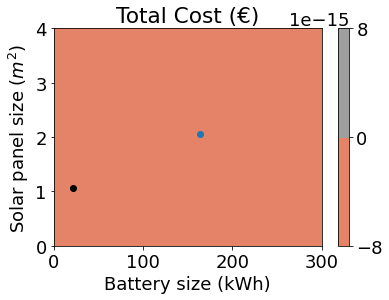

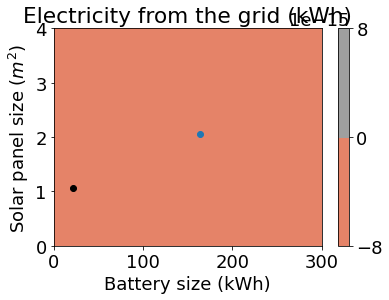

In [ ]:
plt.figure()
plt.contourf(Xbv, Xpv, cost_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Total Cost (€)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.scatter(Xb_opt, Xp_opt,  color='black')
plt.savefig('cost_contour_opt.pdf', bbox_inches='tight')

plt.figure()
plt.contourf(Xbv, Xpv, rcost_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Electricity from the grid (kWh)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.scatter(Xb_opt, Xp_opt,  color='black')
plt.savefig('rcost_contour_opt.pdf', bbox_inches='tight')

## Test Many solutions

Cost zero 404.0
Cost isolated 391.35204081632656
Cost optimal 381.8464739585505
Cost only panels 493.0


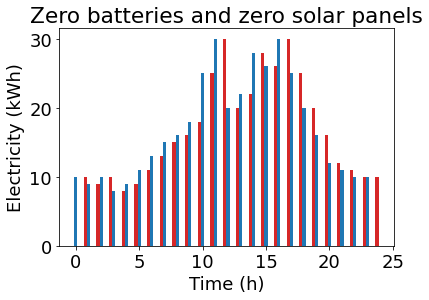

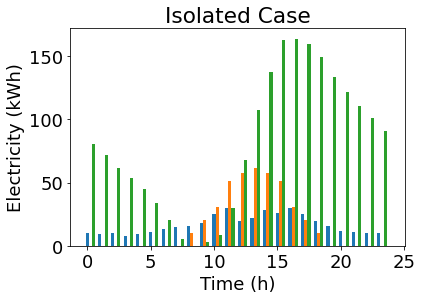

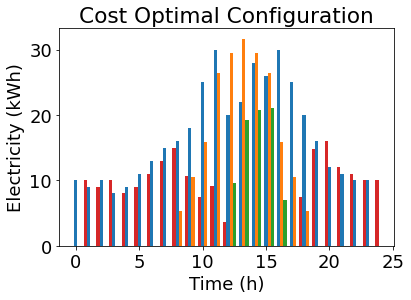

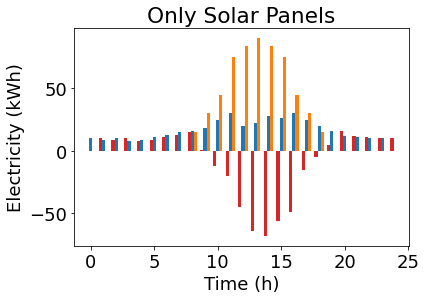

In [ ]:
# Save many solutions
Xp = 0
Xb = 0
qinit = Xb/2
cost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit)
cost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, battery_charge[-1])
plot_fig(t,demand,irradiance,Xp,Xb,battery_charge,e_rv,'00_case.pdf', title='Zero batteries and zero solar panels')
cost, rcost = total_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
print(f'Cost zero {cost}')

Xp = Xp_iso
Xb = Xb_iso
qinit = qinit_iso
cost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit)
cost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, battery_charge[-1])
plot_fig(t,demand,irradiance,Xp,Xb,battery_charge,e_rv,'isolated_case.pdf', title='Isolated Case')
cost, rcost = total_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
print(f'Cost isolated {cost}')


Xp = Xp_opt
Xb = Xb_opt
qinit = Xb/2
cost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit)
cost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, battery_charge[-1])
plot_fig(t,demand,irradiance,Xp,Xb,battery_charge,e_rv,'optinum_case.pdf', title='Cost Optimal Configuration')
cost, rcost = total_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
print(f'Cost optimal {cost}')


Xp = 3
Xb = 0
qinit = Xb/2
cost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit)
cost, battery_charge, casev, e_rv, e_sv, e_bv = electricity_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, battery_charge[-1])
plot_fig(t,demand,irradiance,Xp,Xb,battery_charge,e_rv,'only_panels_case.pdf', title='Only Solar Panels')
cost, rcost = total_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
print(f'Cost only panels {cost}')

## Optimal for all xi (commented for now, it takes several hours)


In [ ]:
# xiv_B = np.linspace(0,1.5,15).tolist()
# xiv_P = np.linspace(0,1.5,15).tolist()
# import time

# Vb, Vp = 1, 1

# Xp_xi = np.zeros([len(xiv_B),len(xiv_P)])
# Xb_xi = np.zeros([len(xiv_B),len(xiv_P)])
# C_opt_xi = np.zeros([len(xiv_B),len(xiv_P)])
# for i,xi_B in enumerate(xiv_B):
#   for j,xi_P in enumerate(xiv_P):
#     Cp= Vp*gt*xi_P
#     Cb = Vb*Ce*(1-eta)*xi_B
#     t = time.process_time()
#     Xb_xi[i,j], Xp_xi[i,j], C_opt_xi[i,j], algorithm = optimal_panels_battery(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance)

# plt.figure()
# plt.contourf(xiv_P, xiv_B, Xb_xi, 30, cmap='RdGy')
# plt.xlabel('xi_P')
# plt.ylabel('xi_B')
# plt.title('Solar Panel Size (m^2)')
# plt.colorbar(cmap='RdGy')
# plt.savefig('xi_xi.pdf', bbox_inches='tight')

In [ ]:
# import scipy.io as sio
# sio.savemat("xi_xi.mat",  {'xiv_P':xiv_P, 'xiv_B': xiv_B,'xiv_B': xiv_B,'Xb_xi':Xb_xi})

In [ ]:
# import scipy.io as sio
# laod = sio.loadmat("xi_xi.mat") 
# #xiv_P= laod['xiv_P']
# #xiv_B=laod['xiv_B']
# #xiv_B=laod['xiv_B']
# Xb_xi=laod['Xb_xi']

In [ ]:
# plt.figure()
# plt.contourf(xiv_P, xiv_B, Xp_xi, 30, cmap='RdGy')
# plt.xlabel('$\\xi_P$')
# plt.ylabel('$\\xi_B$')
# plt.title('Solar Panel Size ($m^2$)')
# plt.colorbar(cmap='RdGy')
# plt.savefig('xi_xi_P.pdf', bbox_inches='tight')

# plt.figure()
# plt.contourf(xiv_P, xiv_B, Xb_xi, 30, cmap='RdGy')
# plt.xlabel('$\\xi_P$')
# plt.ylabel('$\\xi_B$')
# plt.title('Battery Size (kWh)')
# plt.colorbar(cmap='RdGy')
# plt.savefig('xi_xi_B.pdf', bbox_inches='tight')

# plt.figure()
# plt.contourf(xiv_P, xiv_B, C_opt_xi, 30, cmap='RdGy')
# plt.xlabel('$\\xi_P$')
# plt.ylabel('$\\xi_B$')
# plt.title('Optimal Total Cost (€)')
# plt.colorbar(cmap='RdGy')
# plt.savefig('xi_xi_cost.pdf', bbox_inches='tight')

## Multiobjetive

### Problem definition

In [ ]:
class EnergyBuildingMulti(FloatProblem):
    
    def __init__(self, irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp, xp_min):
        super().__init__()

        self.irradiance =irradiance
        self.demand = demand
        self.N = N
        self.Ce= Ce
        self.Cv= Cv
        self.qinit = qinit
        self.Cb= Cb
        self.Vb= Vb
        self.Cp= Cp
        self.Vp= Vp
        
        # initial parameters
        self.number_of_variables = 2 # decision variables
        self.number_of_objectives = 2 
        self.number_of_constraints = 2
        self.lower_bound = [0,0]#[0.0 for _ in range(number_of_variables)]
        self.upper_bound = [xp_min,300] #[1.0 for _ in range(number_of_variables)]
        
        self.obj_directions = [self.MINIMIZE, self.MINIMIZE] # both objectives should be minimized
        self.obj_labels = ['cost', 'co2'] # objectives' name
              
    def evaluate(self, solution) -> FloatSolution:
        '''
        define the way to evaluate one solution, i.e., calculate the objectives of each solution
        '''
        Xp = solution.variables[0]
        Xb = solution.variables[1]
        f1,f2 = total_cost(Xp,Xb,self.irradiance, self.demand, self.N, self.Ce, self.Cv, self.qinit, self.Cb, self.Vb, self.Cp, self.Vp) 
        solution.objectives[0] = f1
        solution.objectives[1] = f2
        
        return solution
    def get_name(self):
        return 'solar_optimum'


def optimal_panels_battery_multi(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min):
  
  energy_building = EnergyBuildingMulti( irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp,xp_min)
  algorithm = NSGAII(
      problem=energy_building,
      population_size=100,
      offspring_population_size=100,
      mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
      crossover=SBXCrossover(probability=1.0, distribution_index=20),
      termination_criterion=StoppingByEvaluations(max_evaluations=25000)
  )

  algorithm.run()
  return algorithm.get_result()

solutions_multi = optimal_panels_battery_multi(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min=8)

### Plot Front

[0.0, 199.61614678298523, 199.61614678298523, 0.0, 18.507467997748904, 168.70503799230295, 78.96304247718653, 70.56022994271517, 141.36276045041177, 129.3267896398686, 4.863422948645628, 166.10495023949298, 14.501087486798255, 145.48350342925957, 9.42316605884628, 127.85694428534492, 89.63555665207298, 91.73575406442528, 74.17888572345524, 103.21574066278757, 47.86946149502238, 50.40725540685386, 113.68361219321974, 107.66265204310596, 149.37420843773504, 45.549321218545465, 34.301199286575844, 157.17132921483505, 28.20594987656989, 160.7701900736954, 176.04828772223777, 193.4389282433418, 63.39211190681606, 15.679730485970387, 37.43033117437354, 100.87850559707869, 7.9039883339709025, 97.27756750330707, 156.23298654724016, 24.532413721345172, 162.04054764763387, 11.070822193340074, 81.87938881923914, 60.587002106983334, 30.38022778822046, 41.40549136808303, 117.76009929532194, 117.76009929532194, 85.83656183028339, 148.66378905930168, 2.7664117962945127, 74.92294873278396, 186.8652369

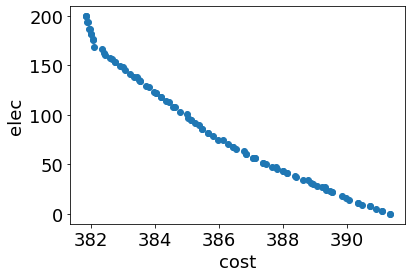

In [ ]:
from jmetal.util.solution import get_non_dominated_solutions, print_function_values_to_file, print_variables_to_file
from jmetal.lab.visualization import Plot, InteractivePlot

nobj = 2
solall = [[solution.objectives[i] for solution in solutions_multi] for i in range(nobj)]

plt.figure()
plt.scatter(solall[0],solall[1])
plt.xlabel('cost')
plt.ylabel('elec')

plot_front = Plot(title='Pareto front approximation', axis_labels=['Cost', 'Electricity from the grid'], reference_front=None)
front = get_non_dominated_solutions(solutions_multi)
plot_front.plot(front, label='Building Optimization', filename='multi_real', format='pdf', normalize = False)

label_obj_2 = ['daily cost (€/day)','electricity from the grid (kWh/day) ']
plot_front_interactive = InteractivePlot( title='Building Energy Optimization', axis_labels=label_obj_2)
plot_front_interactive.plot(front, filename='building_2_obj', normalize=True)

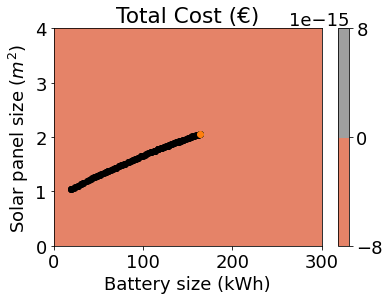

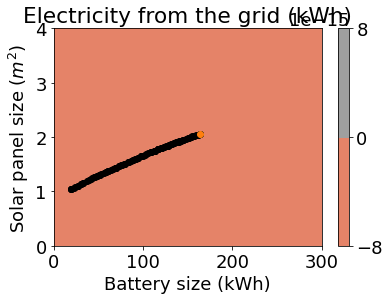

In [ ]:
plt.figure()
plt.contourf(Xbv, Xpv, cost_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Total Cost (€)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
for solution in algorithm_multi.get_result():
  plt.scatter(solution.variables[1], solution.variables[0],  color='black')
plt.scatter(Xb_iso,Xp_iso)
plt.savefig('cost_contour_opt_multi.pdf', bbox_inches='tight')

plt.figure()
plt.contourf(Xbv, Xpv, rcost_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Electricity from the grid (kWh)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
for solution in algorithm_multi.get_result():
  plt.scatter(solution.variables[1], solution.variables[0],  color='black')
plt.scatter(Xb_iso,Xp_iso)
plt.savefig('rcost_contour_opt_multi.pdf', bbox_inches='tight')

## Test with 4 objectives

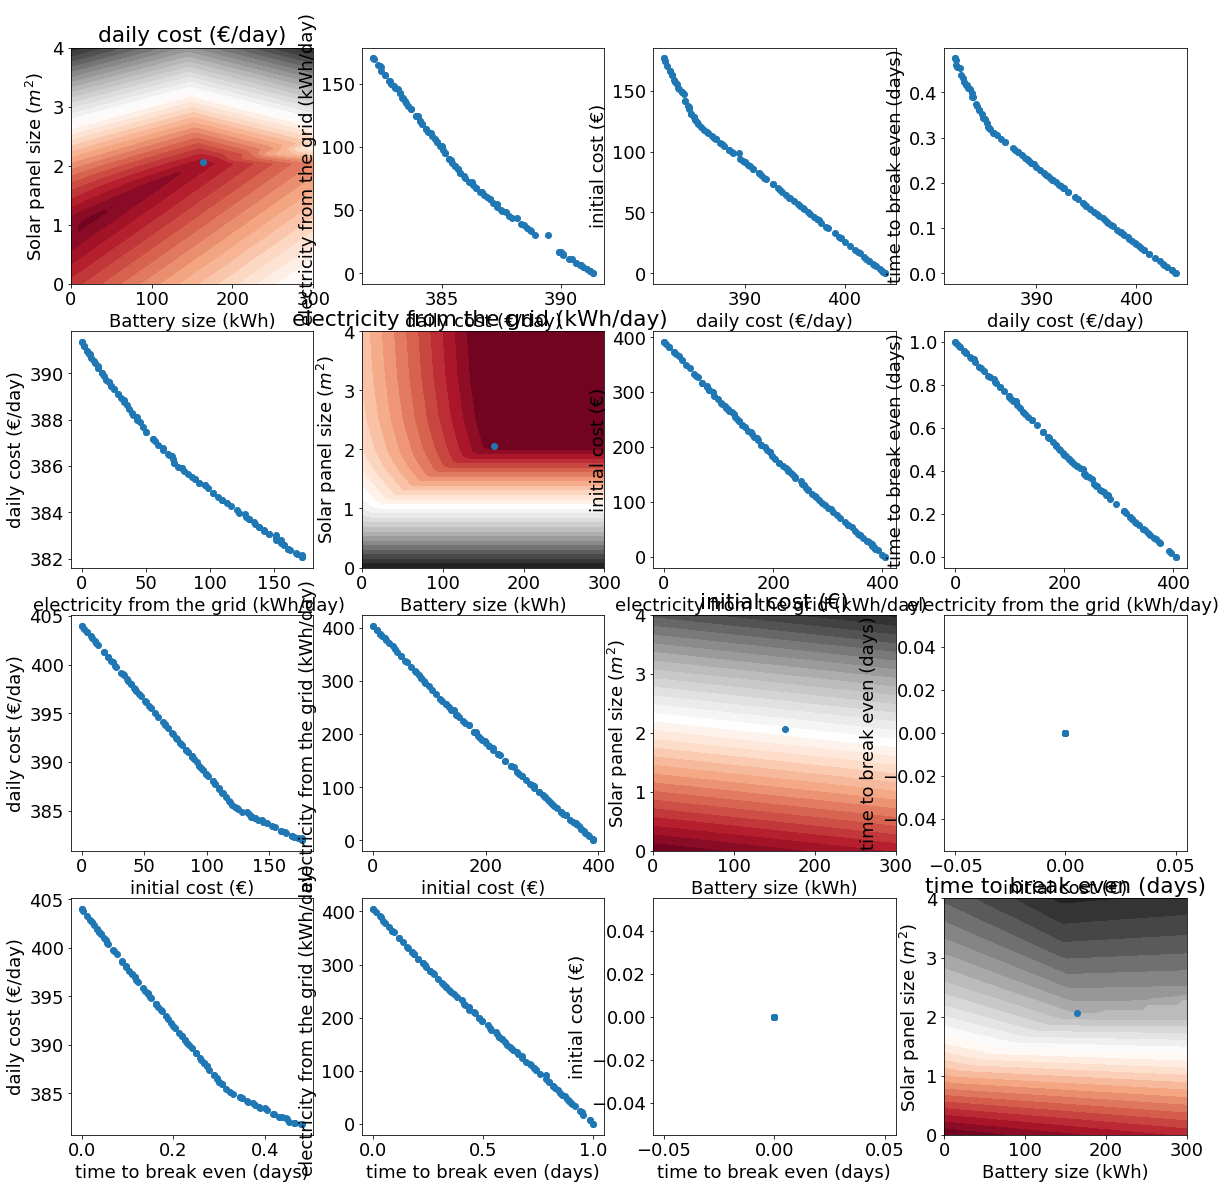

In [ ]:
from jmetal.util.solution import get_non_dominated_solutions, print_function_values_to_file, print_variables_to_file
from jmetal.lab.visualization import Plot

class EnergyBuildingMulti4(FloatProblem):
    
    def __init__(self, irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp, xp_min, i1,i2):
        super().__init__()

        self.irradiance =irradiance
        self.demand = demand
        self.N = N
        self.Ce= Ce
        self.Cv= Cv
        self.qinit = qinit
        self.Cb= Cb
        self.Vb= Vb
        self.Cp= Cp
        self.Vp= Vp
        self.i1 = i1
        self.i2 = i2
        
        # initial parameters
        self.number_of_variables = 2 # decision variables
        self.number_of_objectives = 2 
        self.number_of_constraints = 2
        self.lower_bound = [0,0]#[0.0 for _ in range(number_of_variables)]
        self.upper_bound = [xp_min,300] #[1.0 for _ in range(number_of_variables)]
        
        self.obj_directions = [self.MINIMIZE, self.MINIMIZE] # both objectives should be minimized
        self.obj_labels = ['cost', 'co2'] # objectives' name
              
    def evaluate(self, solution) -> FloatSolution:
        Xp = solution.variables[0]
        Xb = solution.variables[1]
        f = multi_cost(Xp,Xb,self.irradiance, self.demand, self.N, self.Ce, self.Cv, self.qinit, self.Cb, self.Vb, self.Cp, self.Vp)
        solution.objectives[0] = f[self.i1]
        solution.objectives[1] = f[self.i2]
        
        return solution
    def get_name(self):
        return 'solar_optimum'


def optimal_panels_battery_4(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min):

  nobj = 4
  fig, axs = plt.subplots(nobj, nobj,figsize=(20,20))

  label_obj = ['daily cost (€/day)','electricity from the grid (kWh/day) ','initial cost (€)','time to break even (days)']
  front_list = []
  label_front = []
  for i in range(nobj):
    for j in range(nobj):
      if i == j:

        fi = np.zeros([len(Xbv),len(Xpv)])
        for ii,Xb in enumerate(Xbv):
          for jj,Xp in enumerate(Xpv):
            qinit = qinit_iso # Xb/2
            f = multi_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
            fi[jj,ii] = f[i]

        axs[i,j].contourf(Xbv, Xpv, fi, 30, cmap='RdGy')
        axs[i,j].set(xlabel='Battery size (kWh)',ylabel='Solar panel size ($m^2$)')
        axs[i,j].set_title(label_obj[i])
        #axs[i,j].colorbar(cmap='RdGy')
        axs[i,j].scatter(Xb_iso,Xp_iso)
        
      else:
        energy_building = EnergyBuildingMulti4( irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp,xp_min,i,j)
        algorithm = NSGAII(
            problem=energy_building,
            population_size=100,
            offspring_population_size=100,
            mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
            crossover=SBXCrossover(probability=1.0, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations=25000)
        )
        algorithm.run()
        solutions = algorithm.get_result()

        front = get_non_dominated_solutions(solutions)
        front_list.append(front)
        label_front.append( 'Objectives:' + label_obj[i] + ', ' + label_obj[j] )

        number_of_objectives = 2
        solall = [[solution.objectives[i] for solution in solutions] for i in range(number_of_objectives)]

        axs[i,j].scatter(solall[0],solall[1])
        axs[i,j].set(xlabel=label_obj[i],ylabel=label_obj[j])
  fig.savefig('matrix_front.pdf', bbox_inches='tight')

  plot_front = Plot(title='Pareto front approximation', axis_labels=['Cost', 'Electricity from the grid'], reference_front=None)
  plot_front.plot(front_list, label=label_front, filename='many_dummy', format='pdf', normalize = False)

optimal_panels_battery_4(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min=8)

In [ ]:
from jmetal.util.solution import get_non_dominated_solutions, print_function_values_to_file, print_variables_to_file
from jmetal.lab.visualization import Plot, InteractivePlot

class EnergyBuildingMultiManySingle(FloatProblem):
    
    def __init__(self, irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp, xp_min):
        super().__init__()

        self.irradiance =irradiance
        self.demand = demand
        self.N = N
        self.Ce= Ce
        self.Cv= Cv
        self.qinit = qinit
        self.Cb= Cb
        self.Vb= Vb
        self.Cp= Cp
        self.Vp= Vp
        
        # initial parameters
        self.number_of_variables = 2 # decision variables
        self.number_of_objectives = 4 
        self.number_of_constraints = 2
        self.lower_bound = [0,0]#[0.0 for _ in range(number_of_variables)]
        self.upper_bound = [xp_min,300] #[1.0 for _ in range(number_of_variables)]
        
        self.obj_directions = [self.MINIMIZE, self.MINIMIZE, self.MINIMIZE, self.MINIMIZE] # both objectives should be minimized
        self.obj_labels = ['cost', 'co2', 'cinit', 'time to break even'] # objectives' name
              
    def evaluate(self, solution) -> FloatSolution:
        Xp = solution.variables[0]
        Xb = solution.variables[1]
        f = multi_cost(Xp,Xb,self.irradiance, self.demand, self.N, self.Ce, self.Cv, self.qinit, self.Cb, self.Vb, self.Cp, self.Vp)
        solution.objectives[0] = f[0]
        solution.objectives[1] = f[1]
        solution.objectives[2] = f[2]
        solution.objectives[3] = f[3]

        
        return solution
    def get_name(self):
        return 'solar_optimum'

def optimal_panels_battery_Single_Many(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min):
  
  energy_building = EnergyBuildingMultiManySingle( irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp,xp_min)
  algorithm = NSGAII(
      problem=energy_building,
      population_size=100,
      offspring_population_size=100,
      mutation=PolynomialMutation(probability=1.0 / problem.number_of_variables, distribution_index=20),
      crossover=SBXCrossover(probability=1.0, distribution_index=20),
      termination_criterion=StoppingByEvaluations(max_evaluations=25000)
  )

  algorithm.run()
  solutions = algorithm.get_result()

  return solutions

solutions_single = optimal_panels_battery_Single_Many(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min=8)


### Save interactive Plot

In [ ]:
from jmetal.lab.visualization import Plot, InteractivePlot

label_obj = ['daily cost (€/day)','electricity from the grid (kWh/day) ','initial cost (€)','time to break even (days)']

front = get_non_dominated_solutions(solutions_single)
plot_front = Plot(title='Pareto front approximation with 4 objectives', reference_front=None)
plot_front.plot(front, filename='many_single', format='pdf', normalize = False)
plot_front_interactive = InteractivePlot( title='Building Energy Optimization', axis_labels=label_obj)

# Load real demand and irradiance

## Load demand (upload the file)

In [ ]:
import pandas as pd

df = pd.read_csv('2019_input_sensor.csv', parse_dates=['fecha']) #,date_parser=dateparse)
print(df.columns)
df['fecha'] = pd.to_datetime(df['fecha']).dt.date
df.head()

Index(['time', 'centro', 'id', 'fecha', 'consumo', 'reactiva', 'co2',
       'potenciamax', 'potenciaact', 'tarifa', 'coste'],
      dtype='object')


,time,centro,id,fecha,consumo,reactiva,co2,potenciamax,potenciaact,tarifa,coste
0,8759,AP ARQ. LOPEZ OTERO,78922,2019-01-01,4,0,0,4,4,3.1A,772.38
1,8760,AP ARQ. LOPEZ OTERO,78922,2019-01-01,11,0,0,11,11,3.1A,772.38
2,8761,AP ARQ. LOPEZ OTERO,78922,2019-01-01,11,0,0,11,11,3.1A,772.38
3,8762,AP ARQ. LOPEZ OTERO,78922,2019-01-01,11,0,0,11,11,3.1A,772.38
4,8763,AP ARQ. LOPEZ OTERO,78922,2019-01-01,10,0,0,10,10,3.1A,772.38


Number of groups 213
[ 1.  0.  5.  0. 20.  0.  6.  0. 11.  0.  8.  0.  9.  0.  4.  0. 12.  0.
 12.  0.  6.  0.  7.  0.]
shape of numpy array demand (213, 24)


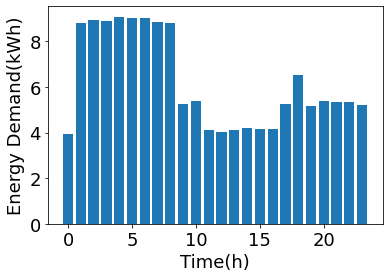

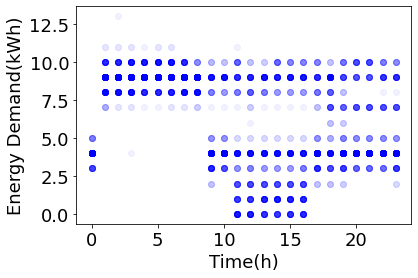

In [ ]:
import numpy as np
group1 = df.groupby( ['fecha'] ) 
print(f'Number of groups {group1.ngroups}')
demand_all = []
#demand_all_np = np.empty([group1.ngroups,24])
demand_all_np = np.empty([24])
print(demand_all_np)

for group in group1:
  outlier = any(group[1].consumo.values) > 15
  if len(group[1].consumo.values) > 22 and all(group[1].consumo.values) < 15:
    demand_all_np = np.vstack ( (demand_all_np,group[1].consumo.values) )
    #print(group[1].consumo.values)
  demand_all.append(group[1].consumo.values)
print(f'shape of numpy array demand {demand_all_np.shape}')

np.array(demand_all)
demand = np.mean(demand_all_np, axis=0)

# Plot Sample Data
plt.rcParams.update({'font.size': 18})
plt.bar(t,demand)
plt.xlabel('Time(h)')
plt.ylabel('Energy Demand(kWh)')
plt.savefig('energy_real.pdf', bbox_inches='tight')

demand_all_np = demand_all_np[1:,:]
plt.figure()
for de in demand_all_np:
  plt.scatter(t,de, color='b', alpha=0.05)
plt.xlabel('Time(h)')
plt.ylabel('Energy Demand(kWh)')
plt.savefig('energy_real_density.pdf', bbox_inches='tight')
plt.show()

### Box plot with real data

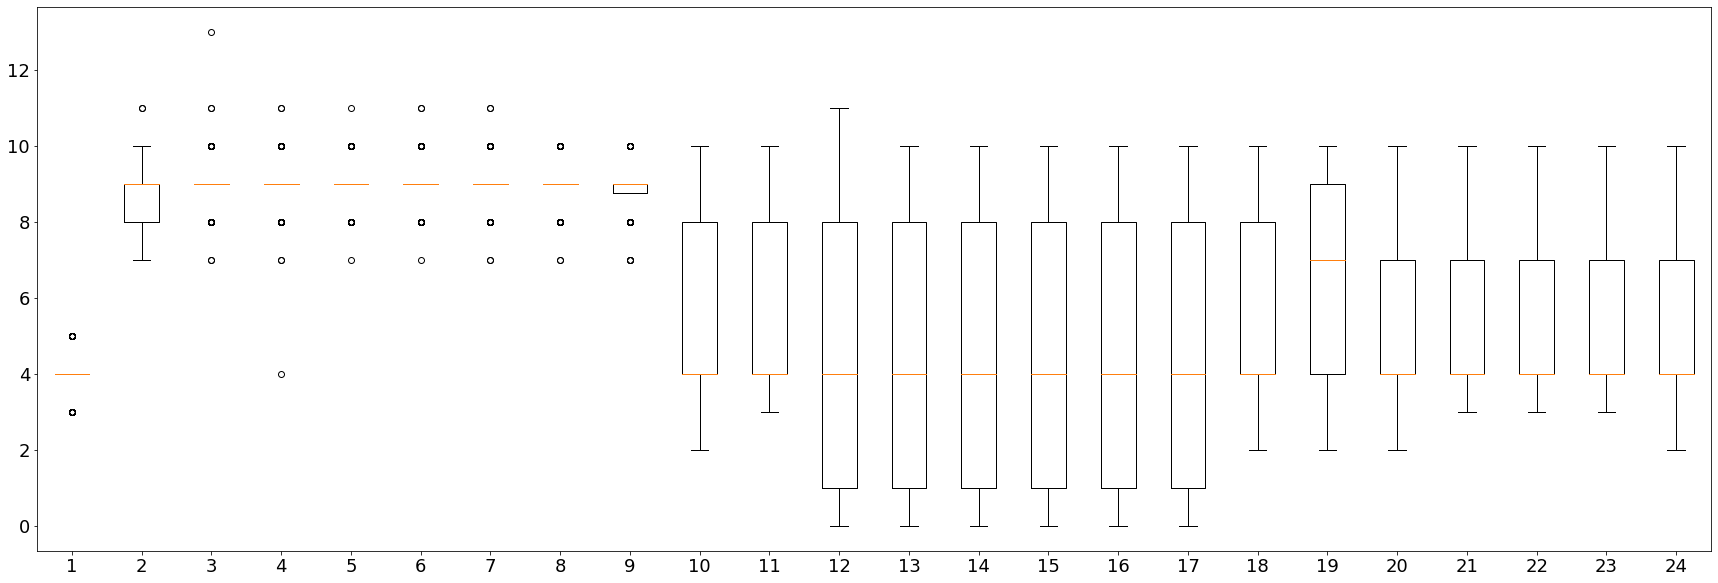

In [ ]:
# Creating boxplot 
plt.figure(figsize=(30,10));
plt.boxplot(demand_all_np);

## Load irradiance

dict_keys(['hourly'])
dict_keys(['time', 'G(i)', 'H_sun', 'T2m', 'WS10m', 'Int'])


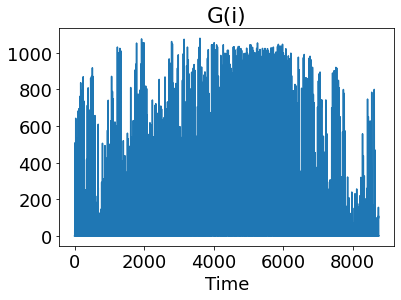

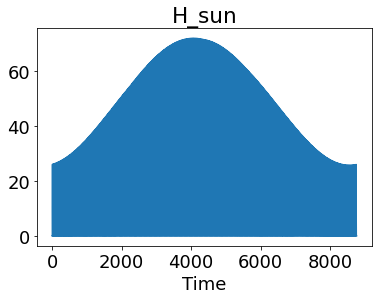

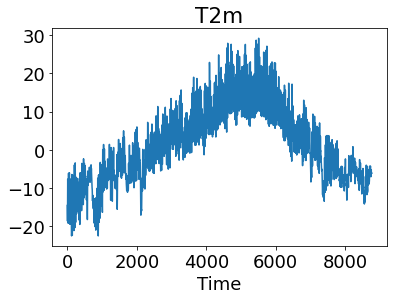

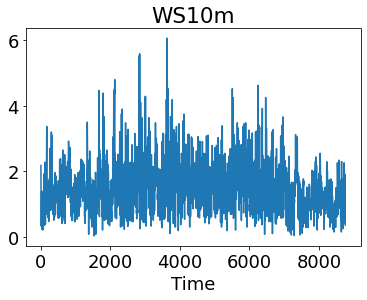

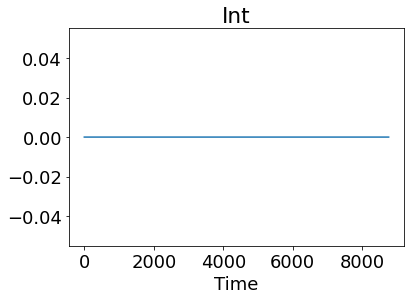

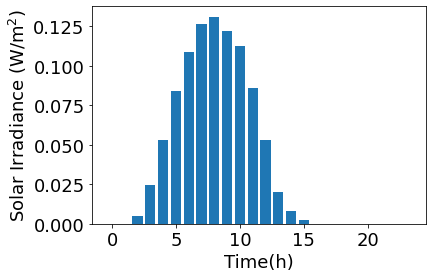

In [ ]:
# load irradiance
import json
from datetime import datetime

with open('PVdata_webscraper.json') as f:
  data = json.load(f)

print(data['outputs'].keys())
print(data['outputs']['hourly'][0].keys())

irradiance_total =  [0] * 24
irradiance_count =  [0] * 24

gi = []
date = []
for hourly_dat in data['outputs']['hourly']:
  date_time_now = datetime.strptime(hourly_dat['time'], '%Y%m%d:%H%M')
  irradiance_total[int(date_time_now.hour)] += hourly_dat['G(i)']
  irradiance_count[int(date_time_now.hour)] += 1
  date.append(date_time_now)
  gi.append( hourly_dat['G(i)'] )

irradiance = [irri/county/1000*0.22 for irri,county in zip(irradiance_total,irradiance_count)]

for key in data['outputs']['hourly'][0].keys():
  if key is not list(data['outputs']['hourly'][0].keys())[0]:
    value = []
    for hourly_dat in data['outputs']['hourly']:
      value.append( hourly_dat[key] )

    plt.figure()
    plt.plot(value)
    plt.title(key)
    plt.xlabel('Time')

plt.figure()
plt.bar(t,irradiance)
plt.xlabel('Time(h)')
plt.ylabel('Solar Irradiance (W/m$^2$)')
plt.savefig('irradiance_real.pdf', bbox_inches='tight')

## Load parameters

In [ ]:
# Load real numbers
N = 24
Ce = 0.109 # euros/kWh
Cv = 0.054 # euros/kWh
Cp = 600 # euros/m^2 #800
Cb = 128 # euros/kWh
Vp = 20*365  # hours
Vb = 15*365  # hours

In [ ]:
# Load real numbers for the future
N = 24
Ce = 0.809 # euros/kWh
Cv = 0.65 # euros/kWh
Cp = 50 # euros/m^2
Cb = 3 # euros/kWh
Vp = 30*365  # hours
Vb = 10*365  # hours

## Compute isolated and zero solutions

Zero cost is 16.23230046948357, relec is 148.92018779342723
d_T is 148.9201877934272, g_t is 0.9369547873972606
xi_P 0.8047912719013134, xi_B 0.4250726442507264, eta 0.4954128440366972
Isolated solution: Xp 158.94063384542628, Xb 76.55665238519192
Variable Electricity cost is 7.283063041541027e-16
Total Electricity cost is 14.853431367259615


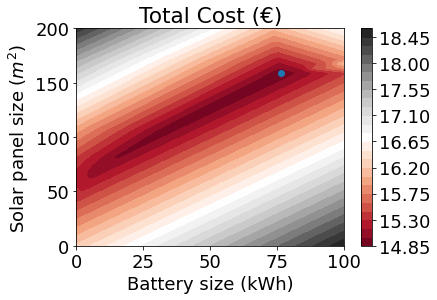

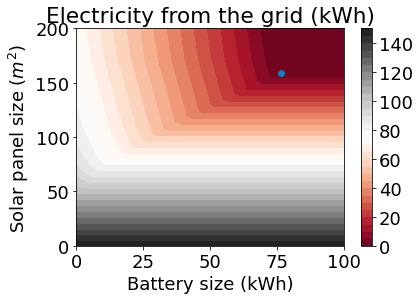

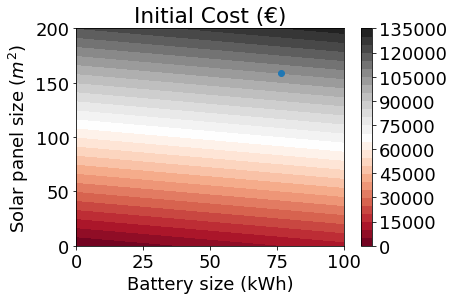

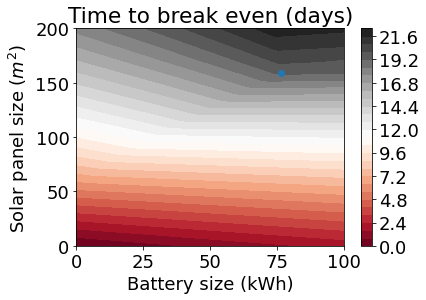

In [ ]:
Xbv = np.linspace(0,100,50).tolist()
Xpv = np.linspace(0,200,50).tolist()

dt = sum(demand)
gt = sum(irradiance)


# Zero solution
cost_zero, rcost_panels_zero = total_cost(0,0,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
print(f'Zero cost is {cost_zero}, relec is {rcost_panels_zero}')

print(f'd_T is {dt}, g_t is {gt}')

xi_P = Cp/Vp/gt/Ce
xi_B = Cb/Vb/Ce/(1-eta)
eta = Cv/Ce

print(f'xi_P {xi_P}, xi_B {xi_B}, eta {eta}')


# Isolated Solution
Xp_iso = dt/gt
N = 24
q = []
qn = 0
for i in range(N):
  qn = qn + Xp_iso*irradiance[i] - demand[i]
  q.append(qn)

Xp = 0
Xb = 300
Xb_iso = max(q)-min(q)
qinit_iso = -min(q)
qinit = qinit_iso
print(f'Isolated solution: Xp {Xp_iso}, Xb {Xb_iso}')
cost_elec_iso, battery_charge_elec_iso, casev_elec_iso, e_rv_elec_iso, e_sv_elec_iso, e_bv_elec_iso = electricity_cost(Xp_iso,Xb_iso,irradiance, demand, N, Ce, Cv, qinit)
print(f'Variable Electricity cost is {cost_elec_iso}')
cost_iso, rcost_panels_elec_iso = total_cost(Xp_iso,Xb_iso,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
print(f'Total Electricity cost is {cost_iso}')


# Plot grid cost
cost_grid = np.zeros([len(Xbv),len(Xpv)])
rcost_grid = np.zeros([len(Xbv),len(Xpv)])
for i,Xb in enumerate(Xbv):
  for j,Xp in enumerate(Xpv):
    qinit = qinit_iso # Xb/2
    f = multi_cost(Xp,Xb,irradiance, demand, N, Ce, Cv, qinit, Cb, Vb, Cp, Vp)
    cost_grid[j,i],rcost_grid[j,i], ci_grid[j,i],T_grid[j,i] =  f[0],f[1],f[2],f[3]/365

plt.figure()
plt.contourf(Xbv, Xpv, cost_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Total Cost (€)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.savefig('xbxp_contour_real.pdf', bbox_inches='tight')

plt.figure()
plt.contourf(Xbv, Xpv, rcost_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Electricity from the grid (kWh)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.savefig('xbxp_rcontour_real.pdf', bbox_inches='tight')

plt.figure()
plt.contourf(Xbv, Xpv, ci_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Initial Cost (€)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.savefig('xbxp_contour.pdf', bbox_inches='tight')

plt.figure()
plt.contourf(Xbv, Xpv, T_grid, 30, cmap='RdGy')
plt.xlabel('Battery size (kWh)')
plt.ylabel('Solar panel size ($m^2$)')
plt.title('Time to break even (years)')
plt.colorbar(cmap='RdGy')
plt.scatter(Xb_iso,Xp_iso)
plt.savefig('xbxp_rcontour.pdf', bbox_inches='tight')

## Compute multiobjective solution

In [ ]:
# Optimize
Xb_opt, Xp_opt, C_opt, algorithm_1 = optimal_panels_battery(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance, 200)

#solutions_2 = optimal_panels_battery_multi(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance, 200)
#plot_front_interactive = InteractivePlot( title='Building Energy Optimization', axis_labels=label_obj_2)
#plot_front_interactive.plot(get_non_dominated_solutions(solutions_2), filename='building_2_obj_real', normalize=True)

#solutions_matrix = optimal_panels_battery_4(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min=8)

solutions_4 = optimal_panels_battery_Single_Many(Ce,Cv,Cp,Cb,Vp,Vb,demand,irradiance,xp_min=8)

plot_front_interactive = InteractivePlot( title='Building Energy Optimization', axis_labels=label_obj)
plot_front_interactive.plot(get_non_dominated_solutions(solutions_4), filename='building_4_obj_real', normalize=True)

Xp 156.50472828261374, Xb 74.54863310438027, Cost 14.855048815821984
